# Step 1

To start off, I want to estimate the number of items you'd get during a tier at a couple different raid sizes using current Shadowlands numbers (1 item per 5 players). The goal is to establish a baseline for what "uniform" loot looks like.

Let us imagine that we have the same `n` players participating in `k` weeks of raid. No absences, no extras. What does that look like?

At first blush, one might assume a binomial distribution is a good fit---we need to be careful because of the way a fixed number of items are handed out (we cannot get 6 items on one boss and 2 on the next, it is always 4 on each and that may impact the variance).

In [1]:
import pandas as pd
import numpy as np
import doctest
import matplotlib.pyplot as plt
import scipy

In [2]:
N_PLAYERS = 20
N_CLEARS = 6 * 4
N_BOSSES = 10

In [273]:
def n_items(player_count):
    """Calculate the number of guaranteed items along with the probability of getting an additional item.
    
    >>> n_items(20)
    (4, 0.0)
    
    >>> n_items(10)
    (2, 0.0)
    
    >>> n_items(30)
    (6, 0.0)
    
    >>> n_items(22)
    (4, 0.4)"""
    PLAYERS_PER_ITEM = 5
    guaranteed = player_count // PLAYERS_PER_ITEM
    extra_chance = player_count % PLAYERS_PER_ITEM / PLAYERS_PER_ITEM
    
    return (guaranteed, extra_chance)

In [274]:
doctest.run_docstring_examples(n_items, globals())

In [5]:
rng = np.random.default_rng()

In [196]:
def generate_data():
    data = np.zeros((N_PLAYERS, N_CLEARS * N_BOSSES))
    (guaranteed, extra_chance) = n_items(N_PLAYERS)
    
    # not doing fancy broadcasting stuff to avoid accidentally ruining variance and/or missing distinctions such as each boss awarding *distinct* players items
    extras = rng.binomial(1, extra_chance, data.shape[1])
    players = np.arange(N_PLAYERS)
    
    for i in range(data.shape[1]):
        n_awards = guaranteed + extras[i]
        awards = rng.choice(players, n_awards, replace=False)
        data[awards, i] = 1
        
    return data

In [226]:
# now we sample a bunch
raw_dataset = np.dstack([generate_data() for i in range(10000)])

In [227]:
dataset = raw_dataset.sum(axis=1)

In [228]:
(np.percentile(dataset, 5), np.percentile(dataset, 50), np.percentile(dataset, 95))

(38.0, 48.0, 58.0)

In [229]:
hist = np.bincount(dataset.flatten().astype('int64')) / dataset.flatten().shape[0]

Text(0.5, 1.0, 'Distribution of Items Received in Numerical Sample of Uniform Process')

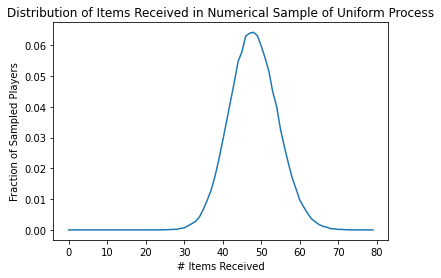

In [230]:
plt.plot(hist)
plt.xlabel('# Items Received')
plt.ylabel('Fraction of Sampled Players')
plt.title('Distribution of Items Received in Numerical Sample of Uniform Process')

In [231]:
normal_data = np.round(rng.normal(np.mean(dataset), np.std(dataset), dataset.flatten().shape)).astype('int64')
normal_hist = np.bincount(normal_data)

Text(0.5, 1.0, 'Distribution of Items Received in Normal Approximation')

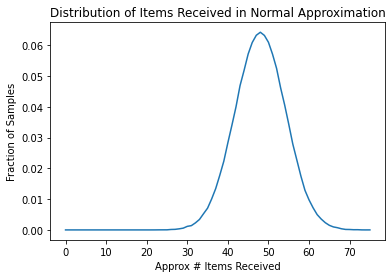

In [232]:
plt.plot(normal_hist / dataset.flatten().shape[0])
plt.xlabel('Approx # Items Received')
plt.ylabel('Fraction of Samples')
plt.title('Distribution of Items Received in Normal Approximation')

In [233]:
from scipy.stats import entropy

In [234]:
entropy(pk=dataset.flatten(), qk=normal_data)

0.01688711010550827

So the (rounded) normal distribution is a good estimation of the number of items received through this uniform discrete process. Now: what about reality?

In [306]:
def calculate_runs(drops):
    drops = drops.T
    runs = []
    since_prev_drop = np.ones(drops.shape[1])
    
    for row in drops:
        current_drops = row == 1
        runs += list(since_prev_drop[current_drops])
        
        since_prev_drop[current_drops] = 0
        since_prev_drop += 1
    return runs

In [307]:
runs = np.concatenate([calculate_runs(raw_dataset[...,i]) for i in range(raw_dataset.shape[2])]).astype('int64')

In [308]:
hist_runs = np.bincount(runs)

(1.0, 20.0)

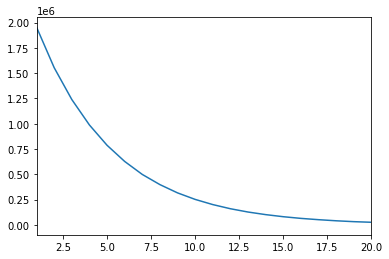

In [309]:
plt.plot(hist_runs)
plt.xlim(1, 20)

In [310]:
np.mean(runs)

4.916743958333333

In [311]:
np.var(runs)

19.247767181525973

In [314]:
exp_runs = rng.geometric(1 / np.mean(runs), len(runs))
hist_exp = np.bincount(exp_runs)

Text(0, 0.5, '# of Occurrences')

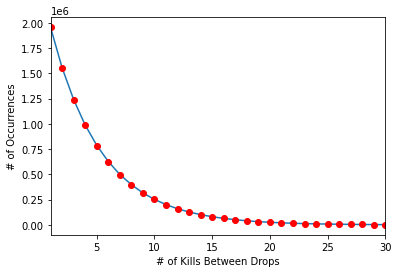

In [315]:
plt.plot(hist_runs)
plt.plot(hist_exp, 'ro')
plt.xlim(1, 30)
plt.xlabel('# of Kills Between Drops')
plt.ylabel('# of Occurrences')

A simple geometric model of the length of time between drops appears to be a decent fit. Need to do some reading about goodness of fit for this.

# Step 2

What if we had BLP? lets implement it as a kind of DKP system. We'll start with no alts etc, but unlike the previous alts change the gap distribution.

In [324]:
def dkp_choice(points, items):
    #return np.argsort(points)[(len(points) - items):]
    return np.random.choice(len(points), items, False, points / points.sum())

In [331]:
def generate_dkp_data():
    data = np.zeros((N_PLAYERS, N_CLEARS * N_BOSSES))
    (guaranteed, extra_chance) = n_items(N_PLAYERS)

    points = np.arange(N_PLAYERS)
    
    # not doing fancy broadcasting stuff to avoid accidentally ruining variance and/or missing distinctions such as each boss awarding *distinct* players items
    extras = rng.binomial(1, extra_chance, data.shape[1])
    players = np.arange(N_PLAYERS)
    
    for i in range(data.shape[1]):
        n_awards = guaranteed + extras[i]
        awards = dkp_choice(points, n_awards)
        points = points + 1
        points[awards] = 0
        data[awards, i] = 1
        
    return data

In [332]:
# now we sample a bunch
drops_dkp = np.dstack([generate_dkp_data() for i in range(1000)])

In [333]:
runs = np.concatenate([calculate_runs(drops_dkp[...,i]) for i in range(drops_dkp.shape[2])]).astype('int64')

(1.0, 30.0)

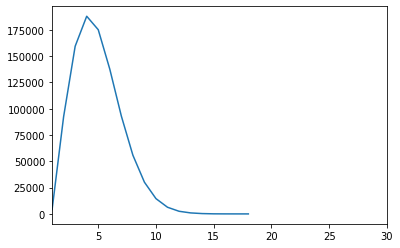

In [334]:
plt.plot(np.bincount(runs))
plt.xlim(1, 30)

In [335]:
np.mean(runs)

4.94964375

In [336]:
np.unique(runs)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18])